In [1]:
import copy
import json, pickle
import glob

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit.primitives import BackendEstimator
from qiskit_ibm_runtime import Estimator as RuntimeEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima, FakeSherbrooke, FakeLimaV2, FakeWashington
from qiskit import QuantumCircuit, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima, FakeBelem

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, random_clifford_circuit
from gnn import ExpValCircuitGraphModel
from qiskit.quantum_info import Clifford
from qiskit_aer.noise import depolarizing_error, coherent_unitary_error, NoiseModel
from noise_utils import AddNoise

from functools import partial

from zne import zne, ZNEStrategy
from zne.noise_amplification import *
from zne.extrapolation import *

import importlib
import mlp
importlib.reload(mlp)
from mlp import MLP1, MLP2, MLP3, encode_data, encode_data_v2_ecr

D = {'output': 'mpl', 'fold': -1, 'idle_wires': False}
DD = {'output': 'mpl', 'fold': 50, 'idle_wires': False}

In [2]:
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()

In [3]:
real_backend = provider.get_backend('ibm_brisbane')

In [4]:
fake_backend = FakeSherbrooke()

## Local
fake_backend_ideal = QasmSimulator() # Noiseless
fake_backend_noisy = AerSimulator.from_backend(fake_backend) # Noisy
stabilizer_simulator = AerSimulator(method='stabilizer')

fake_run_config_ideal = {'shots': 10000, 'backend': fake_backend_ideal, 'name': 'fake_ideal'}
fake_run_config_noisy = {'shots': 10000, 'backend': fake_backend_noisy, 'name': 'fake_noisy'}

In [5]:
def form_all_qubit_observable(observable, measurement_qubits, total_num_qubits):
    """Input observable in non-endian, output observable in endian"""
    assert len(observable) == len(measurement_qubits)
    converted_obs = list('I' * total_num_qubits)
    for qubit, basis in zip(measurement_qubits, list(observable)):
        converted_obs[qubit] = basis
    return ''.join(converted_obs)[::-1]

def get_measurement_qubits(qc, num_measured_qubit):
    measurement_qubits = []
    for measurement in range(num_measured_qubit - 1, -1, -1):
        measurement_qubits.append(qc.data[-1 - measurement][1][0].index)
    return measurement_qubits

In [26]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options
service = QiskitRuntimeService()

In [27]:
import os
from tqdm.notebook import tqdm

def check_f(f, f_ext, step_indices):
    return f.endswith(f_ext) and any([f"step_%02d"%step_index in f for step_index in step_indices])

In [28]:
def load_results(data_dir, step_indices, f_ext='.json'):
    noise_factor_1 = []
    noise_factor_3 = []
    data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if check_f(f, f_ext, step_indices)])
    for data_file in tqdm(data_files, leave=True):
        loaded = json.load(open(data_file, 'r'))
        ret_job_result = service.job(loaded['job_id']).result()
        noise_factor_1.append([ret_job_result.metadata[j]['zne']['noise_amplification']['values'][0] for j in list(range(25))])
        noise_factor_3.append([ret_job_result.metadata[j]['zne']['noise_amplification']['values'][1] for j in list(range(25))])
    return noise_factor_1, noise_factor_3

noise_factor_1, noise_factor_3 = load_results('./data/ising_zne_hardware_twirled/100q_brisbane/job_ids/', [9])

  0%|          | 0/50 [00:00<?, ?it/s]

In [29]:
to_save = {'noise_factor_1': noise_factor_1,
           'noise_factor_3': noise_factor_3}
with open('./zne_mitigated/twirl_100q_brisbane/step09.json', 'w') as file:
    json.dump(to_save, file)

In [30]:
from tqdm.notebook import tqdm
for step_index in [1]:
    with open('./zne_mitigated/twirl_100q_brisbane/step%02d.json'%step_index, 'r') as file:
        loaded = json.load(file)
    noise_factor_1 = np.array(loaded['noise_factor_1'])
    noise_factor_3 = np.array(loaded['noise_factor_3'])

for step_index in tqdm([2, 3, 4, 5, 6, 7, 8, 9]):
    with open('./zne_mitigated/twirl_100q_brisbane/step%02d.json'%step_index, 'r') as file:
        loaded = json.load(file)
    noise_factor_1 = np.concatenate([noise_factor_1, loaded['noise_factor_1']])
    noise_factor_3 = np.concatenate([noise_factor_3, loaded['noise_factor_3']])

  0%|          | 0/8 [00:00<?, ?it/s]

In [31]:
noise_factor_1_tw_avg = noise_factor_1.reshape(noise_factor_1.shape[0], 5, 5).mean(axis=-1)
noise_factor_3_tw_avg = noise_factor_3.reshape(noise_factor_3.shape[0], 5, 5).mean(axis=-1)

In [32]:
slope = (noise_factor_3_tw_avg - noise_factor_1_tw_avg) / 2
zne_mitigated_vals = (noise_factor_1_tw_avg - slope).tolist()
noisy_vals = noise_factor_1_tw_avg.tolist()
len(zne_mitigated_vals)

450

In [33]:
# to_save = {
#     'noisy_vals': noisy_vals,
#     'mitigated_vals': mitigated_vals,
# }
# with open('./zne_mitigated/100q_sherbrooke_30persteps_shots1w_sameJ_second.pk', 'wb') as file:
#     pickle.dump(to_save, file)

In [34]:
# with open('./zne_mitigated/100q_sherbrooke_30persteps_shots1w_sameJ_second.pk', 'rb') as file:
#     loaded = pickle.load(file)
# zne_mitigated_vals = loaded['mitigated_vals']
# noisy_vals = loaded['noisy_vals']

In [36]:
import os
def load_Js(data_dir, step_indices, f_ext='.pk'):
    Js = []
    data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if check_f(f, f_ext, step_indices)])
    for data_file in tqdm(data_files, leave=True):
        for entry in pickle.load(open(data_file, 'rb')):
            Js.append(entry['J'])
    return Js

Js = load_Js('./data/ising_zne_hardware_twirled/100q_brisbane/circuits', [1, 2, 3, 4, 5, 6, 7, 8, 9])
Js = Js[::5]
print(len(Js))

  0%|          | 0/450 [00:00<?, ?it/s]

450


In [37]:
to_df = []
steps = np.repeat([1, 2, 3, 4, 5, 6, 7, 8, 9], 50)

for i, (noisy_exp_val, zne_mitigated, step, J) in tqdm(enumerate(zip(noisy_vals, zne_mitigated_vals, steps, Js)), total=len(noisy_vals)):
    row = dict()
    row['noisy'] = noisy_exp_val
    row['zne_mitigated'] = zne_mitigated
    row['step'] = step
    row['J'] = J

    to_df.append(row)

df = pd.DataFrame(to_df)

  0%|          | 0/450 [00:00<?, ?it/s]

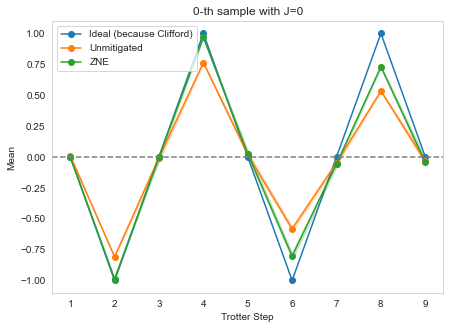

In [38]:
k = 0
num_circ_per_step = 50
new_df = pd.DataFrame(to_df).iloc[k::num_circ_per_step]

import warnings
warnings.filterwarnings('ignore')

for col in new_df.columns:
    if col not in ['step']:
        new_df[f'mean_{col}'] = new_df[col].apply(np.mean)
        new_df[f'ste_{col}'] = new_df[col].apply(np.std) / np.sqrt(5)

plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(7, 5))
steps = sorted(set(new_df.step))
legend_labels = ['Unmitigated', 'ZNE']

plt.plot(steps, [0, -1, 0, 1, 0, -1, 0, 1, 0], label='Ideal (because Clifford)', marker='o')

for i, col in enumerate(['mean_noisy', 'mean_zne_mitigated']):
    plt.plot(steps, new_df[col], label=legend_labels[i], marker='o', color=f'C{i+1}')
    plt.fill_between(x=steps, y1=new_df[col]-new_df['ste_'+'_'.join(col.split('_')[1:])], y2=new_df[col]+new_df['ste_'+'_'.join(col.split('_')[1:])], alpha=0.2, color=f'C{i+1}')
plt.title(f'{k}-th sample with J={Js[k]}')
plt.xlabel('Trotter Step')
plt.ylabel(r'Mean')
xmin, xmax = plt.gca().get_xlim()
plt.xlim([xmin, xmax])
plt.hlines(y=0, xmin=xmin, xmax=xmax, color='gray', linestyles='dashed')
plt.legend()
plt.grid(None)
plt.show()

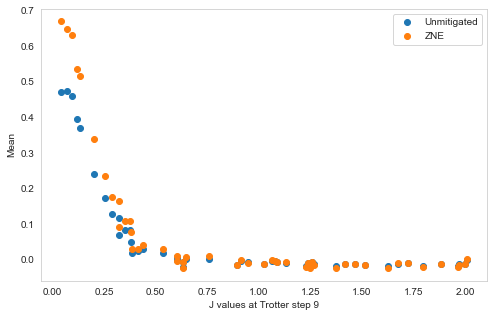

In [39]:
new_df = pd.DataFrame(to_df)
s = 9
new_df = new_df[new_df.step==s].iloc[1:]

import warnings
warnings.filterwarnings('ignore')

for col in new_df.columns:
    if col not in ['step', 'J']:
        new_df[f'mean_{col}'] = new_df[col].apply(np.mean)

plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(8, 5))
samples = list(range(len(set(new_df.index))))
legend_labels = ['Unmitigated', 'ZNE']
for i, col in enumerate(['mean_noisy', 'mean_zne_mitigated']):
    plt.scatter(new_df.J, new_df[col], label=legend_labels[i])
# plt.ylim([-0.8, 0.8])
plt.xlabel(f'J values at Trotter step {s}')
plt.ylabel(r'Mean')
plt.legend()
plt.grid(None)
plt.show()

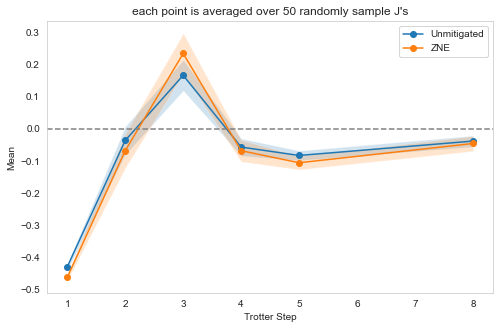

In [20]:
new_df = pd.DataFrame(to_df)

import warnings
warnings.filterwarnings('ignore')

for col in new_df.columns:
    if col not in ['step']:
        new_df[f'mean_{col}'] = new_df[col].apply(np.mean)

new_df_mean = new_df.groupby('step').agg('mean')
new_df_ste = new_df.groupby('step').agg('std') / np.sqrt(len(new_df[new_df['step']==1]))

plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(8, 5))
steps = sorted(set(new_df.step))
legend_labels = ['Unmitigated', 'ZNE']
for i, col in enumerate(['mean_noisy', 'mean_zne_mitigated']):
    plt.plot(steps, new_df_mean[col], label=legend_labels[i], marker='o')
    plt.fill_between(x=steps, y1=new_df_mean[col]-new_df_ste[col], y2=new_df_mean[col]+new_df_ste[col], alpha=0.2)
plt.title("each point is averaged over 50 randomly sample J's")
plt.xlabel('Trotter Step')
plt.ylabel(r'Mean')
xmin, xmax = plt.gca().get_xlim()
plt.xlim([xmin, xmax])
plt.hlines(y=0, xmin=xmin, xmax=xmax, color='gray', linestyles='dashed')
plt.legend()
plt.grid(None)
plt.show()

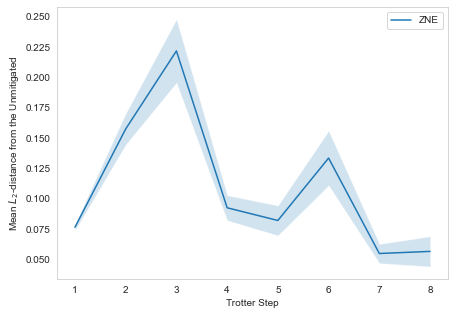

In [23]:
df = pd.DataFrame(to_df)
new_df = df
# new_df = df.iloc[[i for range_start in range(0, len(df), 60) for i in range(range_start+30, range_start+60)]]
# new_df = df.iloc[[i for range_start in range(30, len(df), 60) for i in range(range_start, range_start+30)]]

import warnings
warnings.filterwarnings('ignore')

def l2_dist(list1, list2):
    return np.sqrt(np.sum([(a - b)**2 for a, b in zip(list1, list2)]))

for col in new_df.columns:
    if col not in ['step', 'noisy', 'J']:
        new_df[f'L2_{col}'] = new_df.apply(lambda row: l2_dist(row['noisy'], row[col]), axis=1)

new_df_mean = new_df.groupby('step').agg('mean')
new_df_ste = new_df.groupby('step').agg('std') / np.sqrt(50)

plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(7, 5))
steps = sorted(set(new_df.step))
legend_labels = ['ZNE']
for i, col in enumerate(['L2_zne_mitigated']):
    plt.plot(steps, new_df_mean[col], label=legend_labels[i])
    plt.fill_between(x=steps, y1=new_df_mean[col]-new_df_ste[col], y2=new_df_mean[col]+new_df_ste[col], alpha=0.2)
plt.xlabel('Trotter Step')
plt.ylabel(r'Mean $L_2$-distance from the Unmitigated')
plt.legend()
plt.grid(None)
plt.show()

In [174]:
num_circ_per_step = 30
k = train_test_split = 25
test_circuits = []
test_zne_vals = []
test_noisy_vals = []
test_Js = []
for start_each_step in list(range(len(circuits))[::num_circ_per_step]):
    test_circuits += circuits[start_each_step+k:start_each_step+num_circ_per_step]
    test_zne_vals += zne_mitigated_vals[start_each_step+k:start_each_step+num_circ_per_step]
    test_noisy_vals += noisy_vals[start_each_step+k:start_each_step+num_circ_per_step]
    test_Js += Js[start_each_step+k:start_each_step+num_circ_per_step]

In [175]:
to_df = []
steps = np.repeat(np.arange(1, 11), num_circ_per_step-train_test_split)

models = []
with open('./model/mimic_zne_hardware/100q_rfr_list.pk', 'rb') as f:
    model = pickle.load(f)
models.append((model, 'rfr_list'))

for i, (circ_trans, noisy_exp_val, zne_mitigated, step, J) in tqdm(enumerate(zip(test_circuits, test_noisy_vals, test_zne_vals, steps, test_Js)), total=len(test_noisy_vals)):
    row = dict()
    row['noisy'] = noisy_exp_val
    row['zne_mitigated'] = zne_mitigated
    row['step'] = step
    row['J'] = J

    X, _ = encode_data_v2_ecr([circ_trans], [zne_mitigated], [noisy_exp_val], obs_size=5)

    for j, (model, name) in enumerate(models):
        if name == 'mlp':
            row[name] = model(X).tolist()[0]
        elif name == 'gnn':
            row[name] = model(entry.noisy_0,
                                    entry.observable,
                                    entry.circuit_depth,
                                    entry.x,
                                    entry.edge_index,
                                    entry.batch).tolist()[0]
        elif name in ['ols_full', 'rfr_full']:
            row[name] = model.predict(X).tolist()[0]
        elif name in ['ols', 'rfr']:
            row[name] = model.predict(X[:, -5:]).tolist()[0]
        elif name in ['rfr_list']:
            row[name] = []
            for q, m in enumerate(model):
                row[name].append(m.predict(X))
            row[name] = np.array(row[name]).transpose()[0]
        elif name in ['zne']:
            row[name] = zne_mitigated
        else:
            raise NotImplementedError

    to_df.append(row)

df = pd.DataFrame(to_df)

  0%|          | 0/50 [00:00<?, ?it/s]

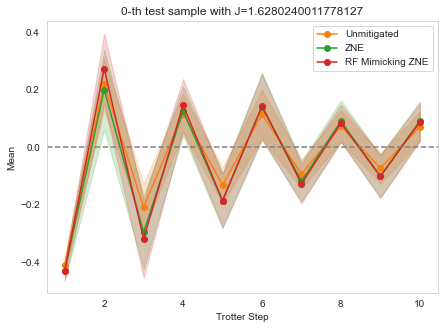

In [177]:
k = 0
new_df = pd.DataFrame(to_df).iloc[k::num_circ_per_step-train_test_split]

import warnings
warnings.filterwarnings('ignore')

for col in new_df.columns:
    if col not in ['step']:
        new_df[f'mean_{col}'] = new_df[col].apply(np.mean)
        new_df[f'ste_{col}'] = new_df[col].apply(np.std) / np.sqrt(num_circ_per_step-train_test_split)

plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(7, 5))
steps = sorted(set(new_df.step))
legend_labels = ['Unmitigated', 'ZNE', 'RF Mimicking ZNE']

for i, col in enumerate(['mean_noisy', 'mean_zne_mitigated', 'mean_rfr_list']):
    plt.plot(steps, new_df[col], label=legend_labels[i], marker='o', color=f'C{i+1}')
    plt.fill_between(x=steps, y1=new_df[col]-new_df['ste_'+'_'.join(col.split('_')[1:])], y2=new_df[col]+new_df['ste_'+'_'.join(col.split('_')[1:])], alpha=0.2, color=f'C{i+1}')
plt.title(f'{k}-th test sample with J={test_Js[k]}')
plt.xlabel('Trotter Step')
plt.ylabel(r'Mean')
xmin, xmax = plt.gca().get_xlim()
plt.xlim([xmin, xmax])
plt.hlines(y=0, xmin=xmin, xmax=xmax, color='gray', linestyles='dashed')
plt.legend()
plt.grid(None)
plt.show()

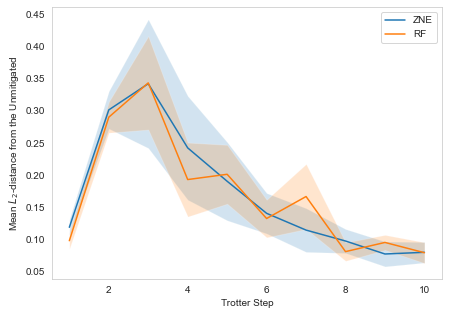

In [165]:
df = pd.DataFrame(to_df)
new_df = df
# new_df = df.iloc[[i for range_start in range(0, len(df), 60) for i in range(range_start+30, range_start+60)]]
# new_df = df.iloc[[i for range_start in range(30, len(df), 60) for i in range(range_start, range_start+30)]]

import warnings
warnings.filterwarnings('ignore')

def l2_dist(list1, list2):
    return np.sqrt(np.sum([(a - b)**2 for a, b in zip(list1, list2)]))

for col in new_df.columns:
    if col not in ['step', 'noisy', 'J']:
        new_df[f'L2_{col}'] = new_df.apply(lambda row: l2_dist(row['noisy'], row[col]), axis=1)

new_df_mean = new_df.groupby('step').agg('mean')
new_df_ste = new_df.groupby('step').agg('std') / np.sqrt(num_circ_per_step-train_test_split)

plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(7, 5))
steps = sorted(set(new_df.step))
legend_labels = ['ZNE', 'RF']
for i, col in enumerate(['L2_zne_mitigated', 'L2_rfr_list']):
    plt.plot(steps, new_df_mean[col], label=legend_labels[i])
    plt.fill_between(x=steps, y1=new_df_mean[col]-new_df_ste[col], y2=new_df_mean[col]+new_df_ste[col], alpha=0.2)
plt.xlabel('Trotter Step')
plt.ylabel(r'Mean $L_2$-distance from the Unmitigated')
plt.legend()
plt.grid(None)
plt.show()